# Stock Market direction predictions

For this project, I aim to predict whether a particular stock is going up or down on a given day, after training a model. The data is provided by the package ISLR in R. The data set contains the daily movements in the Standard & Poor's 500 (S&P) stock index over a 5-year period between 2001 and 2005

# Cleaning data

As the data is provided by the package. I would assume they are clean and no missing data or wrong data type. Anyway, I will first examine the data

In [1]:
library(dplyr)
library(ISLR)

#check the type of the data frame
str(Smarket)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



'data.frame':	1250 obs. of  9 variables:
 $ Year     : num  2001 2001 2001 2001 2001 ...
 $ Lag1     : num  0.381 0.959 1.032 -0.623 0.614 ...
 $ Lag2     : num  -0.192 0.381 0.959 1.032 -0.623 ...
 $ Lag3     : num  -2.624 -0.192 0.381 0.959 1.032 ...
 $ Lag4     : num  -1.055 -2.624 -0.192 0.381 0.959 ...
 $ Lag5     : num  5.01 -1.055 -2.624 -0.192 0.381 ...
 $ Volume   : num  1.19 1.3 1.41 1.28 1.21 ...
 $ Today    : num  0.959 1.032 -0.623 0.614 0.213 ...
 $ Direction: Factor w/ 2 levels "Down","Up": 2 2 1 2 2 2 1 2 2 2 ...


There are 9 columns in the data, with Year representing the year where stock price are recored, the lag variables representating the returns of the stock by lag up to 5 days, volume representating the number of shares traded on the previous day in billions, today representating the percentage return and direction representating whether the market was up or down on that date. 

i will first check if any data is missing:

In [2]:
sum(is.na(Smarket))

[1] 0

So there are no missing values for the data, which is great! It looks like the data type are mostly correct. For the year variable, I think we should convert it to integer, as it would not make sense for a year that is not a whole number:

In [3]:
# convert the Year variable to an integer
Smarket$Year <- as.integer(Smarket$Year)

str(Smarket)

'data.frame':	1250 obs. of  9 variables:
 $ Year     : int  2001 2001 2001 2001 2001 2001 2001 2001 2001 2001 ...
 $ Lag1     : num  0.381 0.959 1.032 -0.623 0.614 ...
 $ Lag2     : num  -0.192 0.381 0.959 1.032 -0.623 ...
 $ Lag3     : num  -2.624 -0.192 0.381 0.959 1.032 ...
 $ Lag4     : num  -1.055 -2.624 -0.192 0.381 0.959 ...
 $ Lag5     : num  5.01 -1.055 -2.624 -0.192 0.381 ...
 $ Volume   : num  1.19 1.3 1.41 1.28 1.21 ...
 $ Today    : num  0.959 1.032 -0.623 0.614 0.213 ...
 $ Direction: Factor w/ 2 levels "Down","Up": 2 2 1 2 2 2 1 2 2 2 ...


Next we check if the data is technically correct. This means 

1) year should be in the past.

2) volume should be bigger than or equal to zero.


In [4]:
library(assertive)

# check if year is in the range
assert_all_are_in_closed_range(Smarket$Year, lower = 2001, upper = 2005)

# check if the volume is negative
 assert_all_are_in_closed_range(Smarket$Volume, lower = 0)

Looks like we are good with the data and is ready to make statistical inference.

# EDA

In [5]:
#look at the the data
dim(Smarket)
summary(Smarket)

[1] 1250    9

      Year           Lag1                Lag2                Lag3          
 Min.   :2001   Min.   :-4.922000   Min.   :-4.922000   Min.   :-4.922000  
 1st Qu.:2002   1st Qu.:-0.639500   1st Qu.:-0.639500   1st Qu.:-0.640000  
 Median :2003   Median : 0.039000   Median : 0.039000   Median : 0.038500  
 Mean   :2003   Mean   : 0.003834   Mean   : 0.003919   Mean   : 0.001716  
 3rd Qu.:2004   3rd Qu.: 0.596750   3rd Qu.: 0.596750   3rd Qu.: 0.596750  
 Max.   :2005   Max.   : 5.733000   Max.   : 5.733000   Max.   : 5.733000  
      Lag4                Lag5              Volume           Today          
 Min.   :-4.922000   Min.   :-4.92200   Min.   :0.3561   Min.   :-4.922000  
 1st Qu.:-0.640000   1st Qu.:-0.64000   1st Qu.:1.2574   1st Qu.:-0.639500  
 Median : 0.038500   Median : 0.03850   Median :1.4229   Median : 0.038500  
 Mean   : 0.001636   Mean   : 0.00561   Mean   :1.4783   Mean   : 0.003138  
 3rd Qu.: 0.596750   3rd Qu.: 0.59700   3rd Qu.:1.6417   3rd Qu.: 0.596750  
 Max. 

I will pair the variables to see if there are important informations:

In [6]:
cor(Smarket)

ERROR: Error in cor(Smarket): 'x' must be numeric


Since the direction variable is not quantitative, we cannot make pair of it to other variables. Instead, I will pair all the variables up except direction:

In [7]:
cor(Smarket[,-9])

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.00000000,0.029699649,0.030596422,0.033194581,0.035688718,0.029787995,0.53900647,0.030095229
Lag1,0.02969965,1.000000000,-0.026294328,-0.010803402,-0.002985911,-0.005674606,0.04090991,-0.026155045
Lag2,0.03059642,-0.026294328,1.000000000,-0.025896670,-0.010853533,-0.003557949,-0.04338321,-0.010250033
Lag3,0.03319458,-0.010803402,-0.025896670,1.000000000,-0.024051036,-0.018808338,-0.04182369,-0.002447647
Lag4,0.03568872,-0.002985911,-0.010853533,-0.024051036,1.000000000,-0.027083641,-0.04841425,-0.006899527
Lag5,0.02978799,-0.005674606,-0.003557949,-0.018808338,-0.027083641,1.000000000,-0.02200231,-0.034860083
Volume,0.53900647,0.040909908,-0.043383215,-0.041823686,-0.048414246,-0.022002315,1.00000000,0.014591823
Today,0.03009523,-0.026155045,-0.010250033,-0.002447647,-0.006899527,-0.034860083,0.01459182,1.000000000


As expected, the correlations between the lag variables and today's returns are close to zero. That is, there is little correlation between today's returns and previous days' return. The only pair worth looking is volume and year.

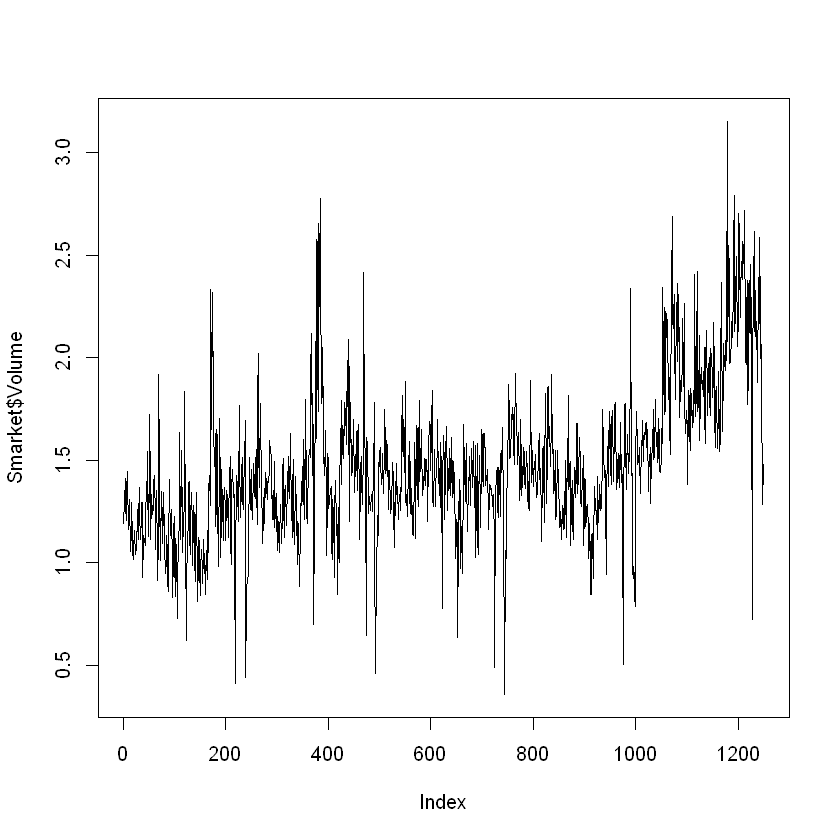

In [8]:
# plotting the volume over the years.
plot(Smarket$Volume, type = 'l')

It looks like the number of shares traded has increased slightly, especially the last two hundred days.

# Model fitting

Next, I will fit a logistic regression model. The resaon behind is we aim to predict the direction, and logistic model seems the best in this case. The dependent variable is Direction, and the independent variables are Lag1 through Lag5 and Volume:

In [9]:
# attach the columns of Smarket 
attach(Smarket)

# Use the information before year 2005 as training data and year 2005 as testing data
train <- (Year < 2005)

# testing data
Smarket.2005 <- Smarket[!train,]

# observations of the testing data
Direction.2005 <- Direction[!train]
length(Direction.2005)

[1] 252

Now I will fit a logistic model for the training data and try to predict the results of the testing data:

In [10]:
# package for logistic model
library(MASS)

# model
log_mod <- glm(Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume, data = Smarket, family = binomial, subset = train)
summary(log_mod)


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select




Call:
glm(formula = Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + 
    Volume, family = binomial, data = Smarket, subset = train)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.302  -1.190   1.079   1.160   1.350  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.191213   0.333690   0.573    0.567
Lag1        -0.054178   0.051785  -1.046    0.295
Lag2        -0.045805   0.051797  -0.884    0.377
Lag3         0.007200   0.051644   0.139    0.889
Lag4         0.006441   0.051706   0.125    0.901
Lag5        -0.004223   0.051138  -0.083    0.934
Volume      -0.116257   0.239618  -0.485    0.628

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1383.3  on 997  degrees of freedom
Residual deviance: 1381.1  on 991  degrees of freedom
AIC: 1395.1

Number of Fisher Scoring iterations: 3


All the p-values in the model are very large (With Lag1 being the smallest but still a lot bigger than 0.05, the standard used alpha to accept or reject null hyponesises). It suggests that the there might not be a big correlation between the variables and the Direction. Now I will compare the results with the observations to see the accuracy of the model:

In [11]:
# prediction probability
log_mod.prob <- predict(log_mod, Smarket.2005, type = "response")

# prediction vector of the model
log_mod.pred <- rep("Down", 252)
log_mod.pred[log_mod.prob > 0.5] <- "Up"

# prediction table comparing to test results
table(log_mod.pred, Direction.2005)

# prediction accuracy
mean(log_mod.pred == Direction.2005)

            Direction.2005
log_mod.pred Down Up
        Down   77 97
        Up     34 44

[1] 0.4801587

We have created a $48\%$ accuracy. This is very bad because have an accuracy lower than $50\%$ means that the model is actually worse than random guessing. Perhaps we can do better by removing variables that is almost uncorrelated to the model assumed by the previous model. Looking back, we can see that the p-values for Lag3, Lag4, Lag5 and Volume is huge, which suggests that those variables does not affect the Direction. Therefore, we are just going to drop those and make a new model:

In [12]:
# new model
log_mod2 <- glm(Direction ~ Lag1 + Lag2, data = Smarket, family = binomial, subset = train)

# prediction probability
log_mod2.prob <- predict(log_mod2, Smarket.2005, type = "response")

# prediction vector of the model
log_mod2.pred <- rep("Down", 252)
log_mod2.pred[log_mod2.prob > 0.5] <- "Up"

# prediction table comparing to test results
table(log_mod2.pred, Direction.2005)

# prediction accuracy
mean(log_mod2.pred == Direction.2005)

             Direction.2005
log_mod2.pred Down  Up
         Down   35  35
         Up     76 106

[1] 0.5595238

The new model shows a $56\%$ accuracy. It slightly increased, but is still not a very good model. However, this is as expected, since there is a rare chance a model can produce a high accuracy on predicting the movements of a stock market.

Next, I will try fitting a KNN model to see if the results are better. It is shown in the above that Lag1 and Lag2 might be the only predictors that affect the response. Therefore, in the KNN model, I am using only Lag1 and Lag2.

In [13]:
# KNN model package
library(class)

# data structure required for KNN model

# predictors for training data
train.X <- cbind(Lag1 ,Lag2)[train ,]
# predictors for training data
test.X <- cbind (Lag1 ,Lag2)[!train ,]
# response for training data
train.Direction <- Direction [train]
# response for testing data
Direction.2005 <- Direction[!train]

Notice for KNN model, the choosing of $K$ affects how good model accuracy is. Since this is a classification problem, the best metric to evaluate the performance model is through the ROC curve and the best model has the highest AUC.

In [14]:
# empty vector
accuracy <- c()

for (i in 1:30) {
  set.seed (1)
# knn model with K ranging from 1 to 30
  knn.pred <- knn(train.X, test.X, train.Direction , k=i)
  table <- table(knn.pred , Direction.2005)
# save accuracy to the empty vector
  accuracy[i] <- (table[1,1] + table[2,2]) / (table[1,1] + table[2,2] + table[1,2] + table[2,1])
}

# K with the highest accuracy
bestK <- which(accuracy == max(K))
bestK

# highest accuracy
accuracy[bestK]

ERROR: Error in which(accuracy == max(K)): object 'K' not found


Here we can see the accuracy is highest with $K = 3,11$. Both of them has an accuracy of $53 \%$, which is even lower than the second logistic regression model. Therefore, I will pick the second logistic model over the KNN models for this project.

# Conclusion

Given the relatively low accuracy of the models created. My reasoning is due to the lack of informations provided on the data set. Generally, the lag return combining with the volume aren't enough to provide insights of whethere the market goes up or down. We need extra information to predict the market. However, based on the model, we can create some strategy revolving around the strngths of the model For example, the model has a higher accuracy on predicting the upward movement of the market:

In [ ]:
# accuracy of predicting up when the market goes up
106 / (76 + 106)

One of the strategies is to buy on days when the model predicts an inceasing market, and avoid trading on days where the model predicts a downward market.